# 📘 Missão da Aula: Construção de Targets e Análises de Comportamento de Crédito

Esta etapa do projeto tem como objetivo principal estruturar os alvos (targets) para modelagem de **Probabilidade de Inadimplência (PD)** e gerar análises complementares que apoiem o entendimento da dinâmica de crédito ao longo do tempo.

---

### ✅ Etapas da Missão:

1. **Testes de Continuidade**  
   Verificação da consistência temporal dos dados por contrato (sem quebras ou lacunas indevidas).

2. **Criação da Coluna `flag_acordo`**  
   Identificação de registros com acordos ou renegociações.

3. **Criação da Coluna `over90`**  
   Flag mensal de inadimplência grave (atraso superior a 90 dias).

4. **Criação da Coluna `mau`**  
   Identificação de contratos irrecuperáveis com base em regras de negócio.

5. **Construção do Grupo Performing**  
   Definição da amostra elegível para modelagem de PD, com base no status performing.

6. **Criação da Coluna `ever90m12`**  
   Indica se o contrato atingiu atraso >90 dias em qualquer mês dos próximos 12 meses (sem considerar acordos).

7. **Criação da Coluna `over90m12`**  
   Indica se o contrato está em atraso >90 dias ao final da janela futura de 12 meses (sem considerar acordos).

8. **Criação da Coluna `target`**  
   Flag final de inadimplência futura, considerando tanto atraso quanto acordos.

9. **Congelamento do Snapshot de Contratos**  
   Seleção de uma linha por contrato para representar o momento de avaliação (janela de decisão).

10. **Curva de Inadimplência (`over90`) por Mês**  
    Análise temporal do volume de contratos inadimplentes mês a mês (painel e snapshot).

11. **Curvas de `ever90m12` e `over90m12` por Mês**  
    Evolução mensal dos indicadores prospectivos de risco (apenas painel).

12. **Construção da Matriz de Transição**  
    Avaliação da migração de status de crédito entre períodos (ex: performing → inadimplente).

13. **Construção da Curva de Cura**  
    Medição da recuperação de contratos inadimplentes ao longo do tempo.

---


In [31]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

## Carregar Dados

In [6]:
historico = pd.read_parquet('full_history.parquet')

# colocar em ordem
historico.sort_values(by=['id_contrato','data_ref'], inplace=True)

In [7]:
rastro_contratos = pd.read_parquet('rastro_contratos.parquet')

In [8]:
rastro_contratos

,id_antigo,id_novo,data_evento
0,10000003,10002500,2015-02-01
1,10000047,10002501,2015-02-01
2,10000048,10002502,2015-02-01
3,10000064,10002503,2015-02-01
4,10000081,10002504,2015-02-01
...,...,...,...
4118,10008505,10012005,2017-12-01
4119,10009551,10012006,2017-12-01
4120,10010700,10012007,2017-12-01
4121,10011432,10012008,2017-12-01


## Teste de Continuidade Temporal

In [ ]:
df = historico.copy()

In [45]:
def continuity_gaps(df):
    """
    Identifica gaps mensais em `data_ref` dentro de cada `id_contrato`.

    Retorna
    -------
    gaps : DataFrame
        id_contrato | data_ant | data_pos | meses_gap
    summary : DataFrame
        Estatísticas dos gaps por contrato
    """
    # 1. ordene
    df = df.sort_values(['id_contrato', 'data_ref']).copy()

    # 2. ordinal mensal (inteiro)
    df['per_ord'] = df['data_ref'].dt.to_period('M').astype(int)

    # 3. diferença de meses (primeira linha = <NA>)
    df['meses_diff'] = (
        df.groupby('id_contrato')['per_ord']
          .diff()
          .astype('Int16')          # agora é numérico, aceita NA
    )

    # 4. data anterior à linha actual
    df['data_ant'] = df.groupby('id_contrato')['data_ref'].shift(1)

    # 5. selecione gaps reais (diferença ≥ 2 meses)
    gaps = (
        df.loc[df['meses_diff'] >= 2]
          .assign(meses_gap=lambda d: d['meses_diff'] - 1)
          [['id_contrato', 'data_ant', 'data_ref', 'meses_gap']]
          .rename(columns={'data_ref': 'data_pos'})
          .reset_index(drop=True)
    )

    # 6. resumo por contrato
    summary = (
        gaps.groupby('id_contrato')['meses_gap']
            .agg(avg_gap='mean',
                 p95_gap=lambda s: np.percentile(s, 95),
                 max_gap='max',
                 gaps_qtd='size')
            .reset_index()
    )

    return gaps, summary


In [ ]:
gaps, gaps_summary = continuity_gaps(historico)
print(gaps_summary.describe())

In [ ]:
# olha valores distintos de meses_diff
tmp = (
    historico.sort_values(['id_contrato', 'data_ref'])
             .assign(per_ord=lambda d: d['data_ref'].dt.to_period('M').astype(int))
)
tmp['meses_diff'] = tmp.groupby('id_contrato')['per_ord'].diff()
print(tmp['meses_diff'].dropna().unique()[:10])

In [ ]:
def missing_months(df):
    """
    Lista todos os meses que deveriam existir no intervalo
    [min(data_ref), max(data_ref)] de cada contrato mas estão ausentes.
    """
    rows = []
    for cid, grp in df.groupby('id_contrato'):
        per = grp['data_ref'].dt.to_period('M')
        full_rng = pd.period_range(per.min(), per.max(), freq='M')
        missing = full_rng.difference(per.unique())
        if not missing.empty:
            rows.extend({'id_contrato': cid, 'mes_faltando': p.to_timestamp()} for p in missing)

    return pd.DataFrame(rows)

faltas = missing_months(historico)
print(faltas.head())
print(faltas['id_contrato'].nunique(), "contratos com pelo menos 1 mês faltando")

In [52]:
def plot_gap_histogram(gaps, bins=20, titulo='Distribuição de gaps (meses)'):
    plt.figure()
    plt.hist(gaps['meses_gap'], bins=bins)
    plt.xlabel('Meses ausentes consecutivos')
    plt.ylabel('Nº de ocorrências')
    plt.title(titulo)
    plt.show()


In [ ]:
def inserir_gaps(df, n_contratos=5, max_gaps_por_contrato=2, seed=42):
    """
    Remove aleatoriamente algumas datas internas de contratos para simular gaps mensais.

    Parâmetros:
    - df: DataFrame com colunas ['id_contrato', 'data_ref']
    - n_contratos: quantos contratos afetar
    - max_gaps_por_contrato: quantas datas (linhas) remover de cada contrato
    - seed: reprodutibilidade
    """
    np.random.seed(seed)
    df = df.copy()
    
    contratos_disponiveis = df['id_contrato'].unique()
    contratos_amostrados = np.random.choice(contratos_disponiveis, n_contratos, replace=False)

    linhas_remover = []

    for cid in contratos_amostrados:
        grupo = df[df['id_contrato'] == cid].sort_values('data_ref')
        datas_possiveis = grupo['data_ref'].iloc[1:-1]  # evitar primeira/última (deixe as pontas)
        if len(datas_possiveis) == 0:
            continue  # contrato muito curto

        datas_remover = np.random.choice(datas_possiveis, 
                                         min(max_gaps_por_contrato, len(datas_possiveis)), 
                                         replace=False)
        ids_remover = grupo[grupo['data_ref'].isin(datas_remover)].index.tolist()
        linhas_remover.extend(ids_remover)

    # remove as linhas
    df_com_gaps = df.drop(index=linhas_remover).reset_index(drop=True)

    return df_com_gaps


In [56]:
# Crie uma cópia com gaps simulados
historico_gaps = inserir_gaps(historico, n_contratos=1000, max_gaps_por_contrato=5)

# Rode novamente a função continuity_gaps
gaps, gaps_summary = continuity_gaps(historico_gaps)

# Visualize os primeiros gaps detectados
display(gaps.head())
display(gaps_summary.describe())

,id_contrato,data_ant,data_pos,meses_gap
0,10000014,2015-01-01,2015-06-01,4
1,10000019,2015-01-01,2015-07-01,5
2,10000031,2015-04-01,2015-06-01,1
3,10000031,2015-06-01,2015-08-01,1
4,10000031,2015-11-01,2016-02-01,2


,avg_gap,p95_gap,max_gap,gaps_qtd
count,859.0,859.000000,859.0,859.0
mean,2.377765,2.749593,2.805588,2.231665
std,1.300495,1.253121,1.252751,1.317313
min,1.0,1.000000,1.0,1.0
25%,1.25,1.850000,2.0,1.0
50%,2.0,2.800000,3.0,2.0
75%,3.0,3.850000,4.0,3.0
max,5.0,5.000000,5.0,5.0


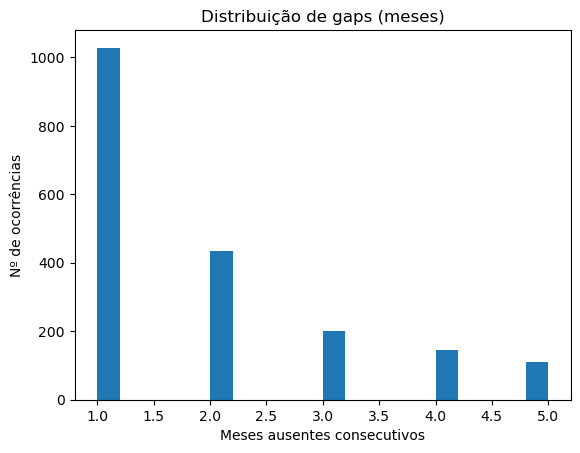

In [57]:
plot_gap_histogram(gaps)

#### Detecção de eventos de re‑aging

In [61]:
def detect_reaging(df, atraso_limite=90):
    """
    Marca eventos de 're‑aging' por contrato.

    Retorna:
      reaging_events: linhas onde ocorre re‑aging
      reaging_summary: contagem por contrato
    """
    df = df.sort_values(['id_contrato', 'data_ref']).copy()

    # atraso no mês anterior
    df['dias_prev'] = (
        df.groupby('id_contrato')['dias_atraso']
          .shift(1)
    )
    cond_reaging = (
        (df['dias_prev'] >= atraso_limite) &              # mês anterior inadimplente
        (df['dias_atraso'] < atraso_limite) &             # volta a performing
        (df['flag_acordo'] == 0)                          # sem acordo registrado
    )

    reaging_events = df.loc[cond_reaging, [
        'id_contrato', 'data_ref', 'dias_prev', 'dias_atraso'
    ]].assign(reaging=1)

    reaging_summary = (
        reaging_events.groupby('id_contrato')
                      .size()
                      .reset_index(name='qtd_reaging')
    )

    return reaging_events, reaging_summary


In [63]:
reaging_ev, reaging_sum = detect_reaging(df)
reaging_ev.head()

,id_contrato,data_ref,dias_prev,dias_atraso,reaging
6,10000000,2015-07-01,90.0,60,1
9,10000000,2015-10-01,90.0,60,1
84,10000009,2015-08-01,90.0,60,1
105,10000012,2015-04-01,90.0,60,1
118,10000013,2015-07-01,90.0,60,1


In [ ]:
df[df['id_contrato']=='10000009'][['data_ref','id_contrato','dias_atraso','over90','mau']]

,data_ref,id_contrato,dias_atraso,over90,mau,flag_acordo
77,2015-01-01,10000009,180,1,1,0
78,2015-02-01,10000009,180,1,1,0
79,2015-03-01,10000009,180,1,1,0
80,2015-04-01,10000009,180,1,1,0
81,2015-05-01,10000009,120,1,1,0
82,2015-06-01,10000009,120,1,1,0
83,2015-07-01,10000009,90,1,1,0
84,2015-08-01,10000009,60,0,0,0
85,2015-09-01,10000009,60,0,0,0
86,2015-10-01,10000009,60,0,0,0


### 1 ▪ Padronize datas para o nível mensal

In [10]:
# df ................................. histórico completo
df = historico.copy()


df['data_ref']      = pd.to_datetime(df['data_ref'])
df['data_ref_mes']  = df['data_ref'].dt.to_period('M').dt.to_timestamp()   # 1º dia do mês


# rastro_contratos ................... trocas/renegociações
rastro_contratos['data_evento']     = pd.to_datetime(rastro_contratos['data_evento'])
rastro_contratos['data_evento_mes'] = (
    rastro_contratos['data_evento'].dt.to_period('M').dt.to_timestamp()
)


In [12]:
rastro_contratos

,id_antigo,id_novo,data_evento,data_evento_mes
0,10000003,10002500,2015-02-01,2015-02-01
1,10000047,10002501,2015-02-01,2015-02-01
2,10000048,10002502,2015-02-01,2015-02-01
3,10000064,10002503,2015-02-01,2015-02-01
4,10000081,10002504,2015-02-01,2015-02-01
...,...,...,...,...
4118,10008505,10012005,2017-12-01,2017-12-01
4119,10009551,10012006,2017-12-01,2017-12-01
4120,10010700,10012007,2017-12-01,2017-12-01
4121,10011432,10012008,2017-12-01,2017-12-01


### 2 ▪ flag_acordo (houve acordo / renegociação naquele mês)

In [13]:
# Eventos para o contrato antigo (renegociado) …
flag_old = (
    rastro_contratos[['id_antigo', 'data_evento_mes']]
    .rename(columns={'id_antigo': 'id_contrato'})
)

# … e para o contrato novo (substituto)
flag_new = (
    rastro_contratos[['id_novo', 'data_evento_mes']]
    .rename(columns={'id_novo': 'id_contrato'})
)

flag_acordo_tb = (
    pd.concat([flag_old, flag_new], ignore_index=True)
    .assign(flag_acordo=1)
    .drop_duplicates()
)


### Faça o merge com o histórico

In [15]:
df = (
    df.merge(
        flag_acordo_tb,
        how='left',
        left_on = ['id_contrato', 'data_ref_mes'],
        right_on=['id_contrato', 'data_evento_mes']
    )
    .drop(columns='data_evento_mes')
)

df['flag_acordo'] = df['flag_acordo'].fillna(0).astype('int8')


In [18]:
df['flag_acordo'].value_counts(normalize=True, dropna=False)*100

flag_acordo
0    96.420572
1     3.579428
Name: proportion, dtype: float64

#### Exemplo rápido de validação

In [24]:
(
    df
    .query('flag_acordo == 1')
    .sort_values(['id_contrato', 'data_ref_mes'])
    .sample(n=10, random_state=0)
)

,id_contrato,data_inicio_contrato,data_ref,safra,dias_atraso,data_ref_mes,flag_acordo
75600,10006232,2015-09-17,2016-07-01,201607,0,2016-07-01,1
30405,10002545,2014-09-07,2015-02-01,201502,0,2015-02-01,1
109911,10010365,2014-08-20,2017-08-01,201708,0,2017-08-01,1
75573,10006228,2014-07-19,2016-07-01,201607,0,2016-07-01,1
113017,10011109,2017-01-22,2017-10-01,201710,0,2017-10-01,1
114234,10011560,2016-11-18,2017-11-01,201711,0,2017-11-01,1
46196,10003807,2014-08-11,2015-08-01,201508,0,2015-08-01,1
72786,10005979,2014-09-22,2016-06-01,201606,0,2016-06-01,1
97874,10008537,2016-10-27,2017-03-01,201703,0,2017-03-01,1
65192,10005314,2014-07-25,2016-03-01,201603,0,2016-03-01,1


### 3 ▪ over90 (atraso ≥ 90 dias)

In [25]:
df['over90'] = (df['dias_atraso'] >= 90).astype('int8')

In [27]:
df['over90'].value_counts(normalize=True, dropna=False)*100

over90
0    83.329571
1    16.670429
Name: proportion, dtype: float64

### 4 ▪ Mau na Origem (status do mês)

In [34]:
# o contrato “novo” gerado pela renegociação recebe flag_acordo = 1 e, portanto, mau = 1 já no mês da originação.

df['mau'] = ((df['over90'] == 1) | (df['flag_acordo'] == 1)).astype('int8')

In [35]:
df['mau'].value_counts(normalize=True, dropna=False)*100

mau
0    79.750143
1    20.249857
Name: proportion, dtype: float64

In [36]:
# Se você quiser que apenas o contrato antigo seja considerado mau e o novo comece “performing”, faça

antigos = set(rastro_contratos['id_antigo'])
df['mau'] = np.where(
    (df['over90'] == 1) | ((df['flag_acordo'] == 1) & df['id_contrato'].isin(antigos)),
    1, 0
).astype('int8')


In [37]:
df['mau'].value_counts(normalize=True, dropna=False)*100

mau
0    82.670637
1    17.329363
Name: proportion, dtype: float64

## Matriz de Transição

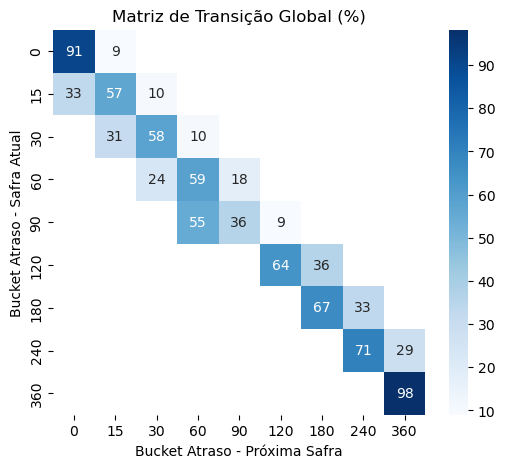

In [9]:
import importlib
import transition_matrix_estimator

importlib.reload(transition_matrix_estimator)

from transition_matrix_estimator import TransitionMatrixLearner

global_learner = TransitionMatrixLearner(buckets=[0,15,30,60,90,120,180,240,360])
global_learner.fit(
    historico,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    #group_col='grupo_homogeneo',
)

global_learner.plot_heatmaps(modes=["global"]); #save_dir="figs/")

In [ ]:
import numpy as np
import importlib
import ever_cure_matrix
importlib.reload(ever_cure_matrix)
from ever_cure_matrix import EverCureMatrixLearner

ecm = EverCureMatrixLearner(buckets=[0, 15, 30, 60, 90])

ecm.fit(
    df_panel,
    horizon=12,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    )

ecm.plot_heatmaps()

plt.show()

In [ ]:
# balanceando target
sampler = TargetSampler(target_ratio=0.10)
balanced = sampler.fit_transform(df_panel, target_col="ever90m12")

#prev = balanced.groupby("safra")["ever90m12"].mean()*100
#print("Prev per safra (balanced):")
#print(prev.head())

In [ ]:
df_snapshot.groupby('sexo')['ever90m12'].mean()*100

In [ ]:
df_snapshot.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
balanced.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
len(balanced), len(df_panel)

In [ ]:
balanced['safra'].value_counts()

In [ ]:
balanced.groupby(by='safra', as_index=True)['ever90m12'].mean()*100

### Contagem de contratos por `grupo_homogeneo`

In [ ]:
df_snapshot['grupo_homogeneo'].value_counts()

### Estatísticas descritivas das variáveis numéricas

In [ ]:
cols_numericas = balanced.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    balanced[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

### Distribuição de `dias_atraso`

In [ ]:
plt.figure()
balanced['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [ ]:
df_snapshot.shape